In [65]:
#%pip install torch torchvision torchaudio
import pandas as pd
from transformers import pipeline
import torch


In [52]:
lazy_df = pl.scan_csv(r"C:\Users\Mert\OneDrive\Desktop\Courses\Financial Big Data\data\nasdaq_exteral_data.csv")

NameError: name 'pl' is not defined

In [53]:
lazy_df.columns

NameError: name 'lazy_df' is not defined

In [54]:
filtered_df = (
    lazy_df
    .select(["Date", "Stock_symbol", "Article_title"])  # Select specific columns
    .filter(pl.col("Article_title").is_not_null())  # Filter null values
    .filter(pl.col("Stock_symbol") == "AAPL")  # Filter Stock_symbol == AAPL 
    .with_columns(pl.col("Date").str.to_datetime("%Y-%m-%d %H:%M:%S UTC"))  # Convert Date to proper datetime format
)

NameError: name 'lazy_df' is not defined

In [55]:
apple_df = (pd.DataFrame(filtered_df.collect())
            .dropna()
            .drop_duplicates()
            .rename({0 : "Date",1 : "Stock_Symbol",2 : "Article_title"}, axis = 1)
            )

NameError: name 'filtered_df' is not defined

In [56]:
apple_df.to_csv("../data/apple_news.csv")

NameError: name 'apple_df' is not defined

### 0. Cleaning our data

In [66]:
#First choose what dataset we want to clean
df_to_clean = pd.read_csv("../data/apple_news.csv")
df_to_clean.head()

,Unnamed: 0,Date,Stock_Symbol,Article_title
0,0,2023-12-16 22:00:00,AAPL,My 6 Largest Portfolio Holdings Heading Into 2024 -- and the Important Investing Lesson I Learned From Each One
1,1,2023-12-16 22:00:00,AAPL,Brokers Suggest Investing in Apple (AAPL): Read This Before Placing a Bet
2,2,2023-12-16 21:00:00,AAPL,"Company News for Dec 19, 2023"
3,3,2023-12-16 21:00:00,AAPL,NVIDIA (NVDA) Up 243% YTD: Will It Carry Momentum in 2024?
4,4,2023-12-16 21:00:00,AAPL,"Pre-Market Most Active for Dec 19, 2023 : BMY, SQQQ, NIO, UBS, TQQQ, UBER, NVDA, AAPL, GOTU, CAN, TSLA, PLTR"


In [67]:
pd.set_option('display.max_colwidth', None)
print(df_to_clean["Article_title"].head())

0    My 6 Largest Portfolio Holdings Heading Into 2024 -- and the Important Investing Lesson I Learned From Each One
1                                          Brokers Suggest Investing in Apple (AAPL): Read This Before Placing a Bet
2                                                                                      Company News for Dec 19, 2023
3                                                         NVIDIA (NVDA) Up 243% YTD: Will It Carry Momentum in 2024?
4       Pre-Market Most Active for Dec 19, 2023 : BMY, SQQQ, NIO, UBS, TQQQ, UBER, NVDA, AAPL, GOTU, CAN, TSLA, PLTR
Name: Article_title, dtype: object



TODO :
-Remove unnamed index column
-Parse the Date column to datetime format.
-Incorporate sentiment analysis with Dis roberta to generate sentiment scores

In [68]:
df_to_clean = df_to_clean.drop(columns=['Unnamed: 0'])
df_to_clean['Date'] = pd.to_datetime(df_to_clean['Date'])
df_filtered = df_to_clean[df_to_clean['Article_title'].str.contains(r'\b(Apple|AAPL)\b', case=False, na=False)]

/var/folders/00/1h1mgh1j2gb16vq65twfjnjh0000gn/T/ipykernel_8024/3341075066.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtered = df_to_clean[df_to_clean['Article_title'].str.contains(r'\b(Apple|AAPL)\b', case=False, na=False)]


In [69]:

df_filtered.to_csv("../data/clean/apple_news_c.csv")
df_filtered

,Date,Stock_Symbol,Article_title
1,2023-12-16 22:00:00,AAPL,Brokers Suggest Investing in Apple (AAPL): Read This Before Placing a Bet
4,2023-12-16 21:00:00,AAPL,"Pre-Market Most Active for Dec 19, 2023 : BMY, SQQQ, NIO, UBS, TQQQ, UBER, NVDA, AAPL, GOTU, CAN, TSLA, PLTR"
6,2023-12-16 20:00:00,AAPL,AAPL Quantitative Stock Analysis
15,2023-12-16 04:00:00,AAPL,"After Hours Most Active for Dec 18, 2023 : PACB, AAPL, VTIP, EDAP, FTNT, AMZN, HPE, SKT, VZ, MRK, BVN, PFE"
16,2023-12-16 04:00:00,AAPL,"Technology Sector Update for 12/18/2023: PCT, ADBE, AAPL, EBIX"
...,...,...,...
9099,2020-03-10 00:00:00,AAPL,Peloton Shares Tick To Session Low As Hearing Report Apple Working On 'Guided Workout' Fitness App
9105,2020-03-10 00:00:00,AAPL,"UBS Maintains Buy on Apple, Lowers Price Target to $335"
9115,2020-05-31 00:00:00,AAPL,"Apple CEO Writes To Employees About George Floyd Death, Urges For 'Better, More Just World For Everyone'"
9135,2020-05-28 00:00:00,AAPL,"Tredje AP-fonden Buys Microsoft Corp, Amazon.com Inc, Apple Inc, Sells iShares U.S. ..."


### 1. News-data Preprocessing

Assume that the dataset of the news is a constant flow of the news, then we try to construct a stochastic process on sentiment: use distrillroberta to generate sentiment(positive, neutral, negative) of the news headline and labelled the as (1, 0, -1) scores. Noted that the news are always released in two ways: one is that the news are released at midnight(or non-trading time) in batches, the others are released during trading time without batches(a flow-released news). For batch-released news, average the sentiment score.

THe formula for the stochastic process is be written as 

$$
I_t^s = \sum_{j} g(f(e_{jt}^{s})), 
g(x) = \begin{cases} 1, x = "Positive"\\
0, x = "Neutral"\\
-1, x = "Negative"\\
\end{cases},

f(x) = roBERTa(x),

$$

$f(x)$ is the pretrained sentiment classifier. $e_{jt}^{s}$ means the $j$-th embedding of the news headline at time $t$ for the stock $s$.

**Note**: time $t$ is not the natural time for trading, but it's proxy time interval between the new release, and it differs from stock to stock. Think of it as some sort of jump process.

In [70]:
cleaned_df = pd.read_csv("../data/clean/apple_news_c.csv")
cleaned_df.head(2)

,Unnamed: 0,Date,Stock_Symbol,Article_title
0,1,2023-12-16 22:00:00,AAPL,Brokers Suggest Investing in Apple (AAPL): Read This Before Placing a Bet
1,4,2023-12-16 21:00:00,AAPL,"Pre-Market Most Active for Dec 19, 2023 : BMY, SQQQ, NIO, UBS, TQQQ, UBER, NVDA, AAPL, GOTU, CAN, TSLA, PLTR"


In [71]:
#%pip install torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# We will use distilRoberta-financial-sentiment a fine-tuned version of distilroberta-base on the financial_phrasebank dataset
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Let's apply the discussed sentiment analysis
def classify_sentiment(article):
    sentiment_result = sentiment_pipeline(article)[0]
    label = sentiment_result['label']
    if label == "positive":
        return 1
    elif label == "negative":
        return -1
    else:
        return 0

# Now we need to merge the sentiment scores to the dataset (AND AFTER MERGE INDEX)
cleaned_df['Sentiment'] = cleaned_df['Article_title'].apply(classify_sentiment)
cleaned_df.to_csv("../data/processed/processed_news_data_with_sent.csv", index=False)
print("Sentiment classification completed and saved to processed_news_data_with_sent.csv.")


Device set to use mps:0


KeyboardInterrupt: 

In [63]:
merged_df = pd.read_csv("../data/processed/processed_news_data_with_sent.csv")
merged_df.head(2)

,Unnamed: 0,Date,Stock_Symbol,Article_title,Sentiment
0,1,2023-12-16 22:00:00,AAPL,Brokers Suggest Investing in Apple (AAPL): Read This Before Placing a Bet,0
1,4,2023-12-16 21:00:00,AAPL,"Pre-Market Most Active for Dec 19, 2023 : BMY, SQQQ, NIO, UBS, TQQQ, UBER, NVDA, AAPL, GOTU, CAN, TSLA, PLTR",0


### 2. Price-data preprocessing

Discretize the tick-by-tick data to align with the news-data, by identifying the return of the price. When the batch news are released in non-trading time, assume that the traders in the market will react to the news as soon as the trading time starts, for flow-released news, assume that the market participants will react as soon as the information of the news is understood. There will be two hyperparameter: the time-lag between the new release and the market reaction, and the fixed timeframe that uses to calculate the return of the price. Set the return of the stock as positive, stable and negative under a threshold and label it as (1,0,-1). Then we construct a stochastic process for stock return.

The formula for the stochastic process of the discretized return can be written as 

$$
R_{t}^{s} = h(\log \frac{P_{t + \delta}^{s}}{P_{t}^{s}}), 

h(x) = \begin{cases}1, x > \gamma \\ 0, \|x\| \leq \gamma \\ -1, x < -\gamma\end{cases},

\gamma, \delta > 0
$$

$P_{t}^{s}$ is the price of stock $s$ at time $t$, $\delta$ is the timeframe for the return calculation, $\gamma$ is the threshold of classifying the return.

#### 2.1 Cleaning the price dataset

In [87]:
import pandas as pd
import numpy as np

data = pd.read_csv("../data/quotes/apple_quotes.csv")

print("Columns in the dataset:", data.columns)

data.columns = data.columns.str.strip()
for column in ['Close', 'Open', 'High', 'Low']:
    if column in data.columns:
        data[column] = data[column].replace('[\$,]', '', regex=True).astype(float)
    else:
        print(f"Column '{column}' not found in the dataset.")
        
if 'Close' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
    data = data.sort_values(by='Date')

    delta = 1
    data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(delta))

    #classification function h(x)
    def classify_return(x, gamma):
        if x > gamma:
            return 1  # Positive return
        elif x < -gamma:
            return -1  # Negative return
        else:
            return 0  # Stable return

    from collections import Counter

    #thresholds to test
    #gamma_values = np.linspace(0.01, 0.1, 10)

    # Store the label distribution for each gamma
    #label_distributions = {}

    #for gamma in gamma_values:
    #    data['Return_Label'] = data['Log_Return'].apply(lambda x: classify_return(x, gamma))
    #    label_distributions[gamma] = Counter(data['Return_Label'])

    # Print the distributions for analysis
    for gamma, dist in label_distributions.items():
        print(f"Gamma: {gamma:.2f}, Distribution: {dict(dist)}")


    # Let's define the threshold for labeling and the time lag for the logreturn we disscussed : HYPERPARAM TO CHOOSE in a optimum way
    gamma = 0.01

    data['Return_Label'] = data['Log_Return'].apply(lambda x: classify_return(x, gamma))

    # Save the processed dataset
    data.to_csv("../data/processed/processed_apple_historical_data.csv", index=False)
else:
    print("Column 'Close' not found in the dataset. Unable to calculate Log_Return.")

Columns in the dataset: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Gamma: 0.01, Distribution: {0: 1428, 1: 618, -1: 472}
Gamma: 0.02, Distribution: {0: 2108, 1: 206, -1: 204}
Gamma: 0.03, Distribution: {0: 2364, 1: 81, -1: 73}
Gamma: 0.04, Distribution: {0: 2447, 1: 34, -1: 37}
Gamma: 0.05, Distribution: {0: 2483, 1: 18, -1: 17}
Gamma: 0.06, Distribution: {0: 2501, 1: 8, -1: 9}
Gamma: 0.07, Distribution: {0: 2512, 1: 3, -1: 3}
Gamma: 0.08, Distribution: {0: 2514, 1: 1, -1: 3}
Gamma: 0.09, Distribution: {0: 2516, -1: 2}
Gamma: 0.10, Distribution: {0: 2516, -1: 2}


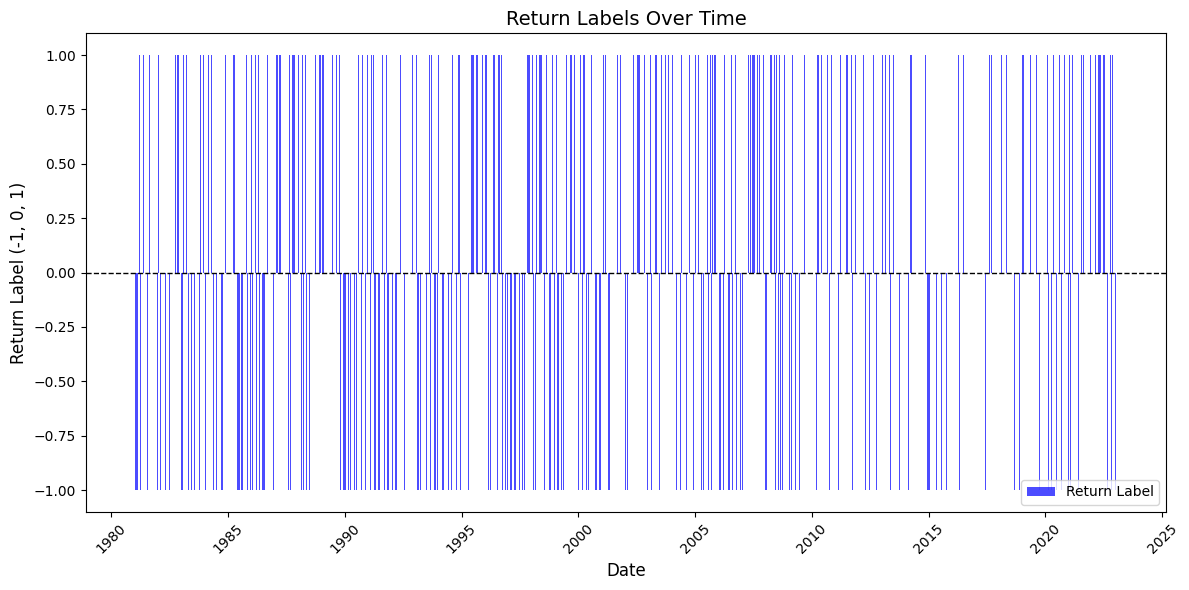

In [88]:
#γ=0.01, as it provides a more balanced distribution across the three labels:
import matplotlib.pyplot as plt

# Ensure 'Log_Return' column is created
if 'Log_Return' not in data.columns:
	delta = 1
	if 'Close' in data.columns:
		data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(delta))
	else:
		print("Column 'Close' not found in the dataset.")
		# Handle the error or exit
		raise KeyError("Column 'Close' not found in the dataset.")

# Ensure 'Return_Label' column is created
if 'Return_Label' not in data.columns:
	gamma = 0.01  # !!!!!!!!!!!!!!
	data['Return_Label'] = data['Log_Return'].apply(lambda x: classify_return(x, gamma))

plt.figure(figsize=(12, 6))
plt.bar(data['Date'], data['Return_Label'], color='b', alpha=0.7, label='Return Label')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line for 0
plt.title('Return Labels Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Return Label (-1, 0, 1)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

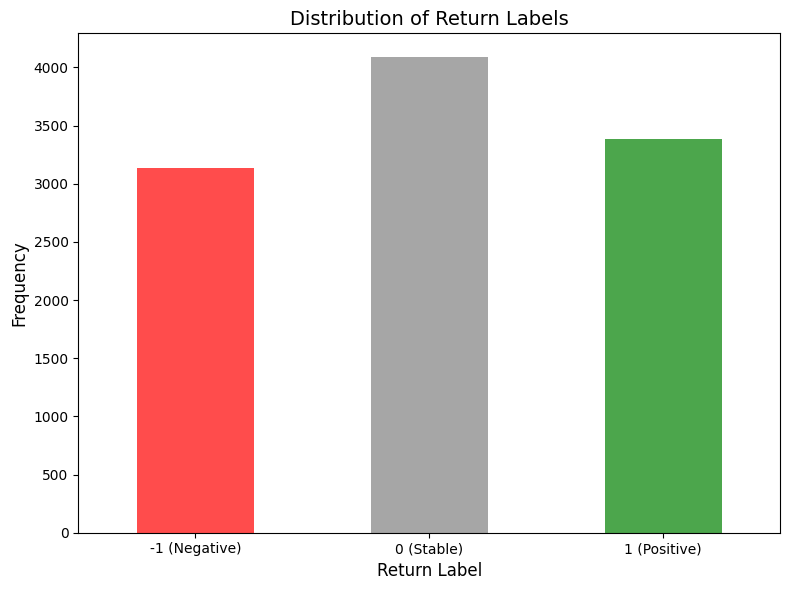

In [89]:
#import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
data['Return_Label'].value_counts().sort_index().plot(kind='bar', color=['red', 'gray', 'green'], alpha=0.7)
plt.title('Distribution of Return Labels', fontsize=14)
plt.xlabel('Return Label', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=['-1 (Negative)', '0 (Stable)', '1 (Positive)'], rotation=0)
plt.tight_layout()
plt.show()

We need to Adjust Threshold ... -> need to use 
1. Balance Class Distribution
The goal is to have a balanced distribution of labels (-1, 0, 1) to avoid class imbalance issues.
Steps:

-Iterate over different values of 
γ (e.g., 0.01, 0.02, ..., 0.1)

-Calculate the distribution of return labels for each 
γ

-Select the 
γ value where the labels are relatively balanced

In [90]:
#### 2.2 Linking it to the news data

In [91]:
returns_data = pd.read_csv('../data/processed/processed_apple_historical_data.csv')
sentiment_data = pd.read_csv('../data/processed/processed_news_data_with_sent.csv')
sentiment_data.head(15)

,Unnamed: 0,Date,Stock_Symbol,Article_title,Sentiment
0,1,2023-12-16 22:00:00,AAPL,Brokers Suggest Investing in Apple (AAPL): Read This Before Placing a Bet,0
1,4,2023-12-16 21:00:00,AAPL,"Pre-Market Most Active for Dec 19, 2023 : BMY, SQQQ, NIO, UBS, TQQQ, UBER, NVDA, AAPL, GOTU, CAN, TSLA, PLTR",0
2,6,2023-12-16 20:00:00,AAPL,AAPL Quantitative Stock Analysis,0
3,15,2023-12-16 04:00:00,AAPL,"After Hours Most Active for Dec 18, 2023 : PACB, AAPL, VTIP, EDAP, FTNT, AMZN, HPE, SKT, VZ, MRK, BVN, PFE",0
4,16,2023-12-16 04:00:00,AAPL,"Technology Sector Update for 12/18/2023: PCT, ADBE, AAPL, EBIX",0
5,18,2023-12-16 04:00:00,AAPL,Apple To Halt Sale Of Watch Series 9 And Ultra 2,-1
6,20,2023-12-16 02:00:00,AAPL,"Technology Sector Update for 12/18/2023: ADBE, AAPL, EBIX",0
7,21,2023-12-16 00:00:00,AAPL,FOCUS-Goldman Sachs faces rocky exit from Apple credit card partnership,-1
8,27,2023-12-16 00:00:00,AAPL,"Apple to halt US sales of Series 9, Ultra 2 smartwatches on patent dispute",-1
9,32,2023-12-16 00:00:00,AAPL,This Is Apple's Most Important Growth Product Today (Hint: It's Not the iPhone),0


In [92]:
returns_data.head(15)

,Date,Open,High,Low,Close,Adj Close,Volume,Log_Return,Return_Label
0,1981-01-02,0.154018,0.155134,0.154018,0.154018,0.119849,21660800,NaN,0
1,1981-01-05,0.151228,0.151228,0.150670,0.150670,0.117244,35728000,-0.021977,-1
2,1981-01-06,0.144531,0.144531,0.143973,0.143973,0.112032,45158400,-0.045466,-1
3,1981-01-07,0.138393,0.138393,0.137835,0.137835,0.107256,55686400,-0.043568,-1
4,1981-01-08,0.135603,0.135603,0.135045,0.135045,0.105085,39827200,-0.020449,-1
5,1981-01-09,0.142299,0.142857,0.142299,0.142299,0.110730,21504000,0.052322,1
6,1981-01-12,0.142299,0.142299,0.141183,0.141183,0.109861,23699200,-0.007874,0
7,1981-01-13,0.136719,0.136719,0.136161,0.136161,0.105953,23049600,-0.036219,-1
8,1981-01-14,0.136719,0.137277,0.136719,0.136719,0.106388,14291200,0.004090,0
9,1981-01-15,0.139509,0.140625,0.139509,0.139509,0.108559,14067200,0.020201,1


News published after 4 PM is assigned to the next trading day using lambda, 
Sentiment data is aggregated by trading day using the mean,
left join with returns_data to retain only rows with both sentiment and return data
Rows without corresponding sentiment data are dropped using

In [93]:
import pandas as pd
import numpy as np

# 1. First, let's look at both datasets before any processing
print("Original Returns Data Dates:")
print(returns_data['Date'].sort_values().unique()[:5], "...")
print(returns_data['Date'].sort_values().unique()[-5:])

print("\nOriginal Sentiment Data Dates:")
print(sentiment_data['Date'].sort_values().unique()[:5], "...")
print(sentiment_data['Date'].sort_values().unique()[-5:])

# 2. Process and check sentiment data
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])
sentiment_data['Trading_Date'] = sentiment_data['Date'].apply(
    lambda x: (x + pd.Timedelta(days=1)).date() if x.hour >= 16 else x.date()
)

print("\nUnique Trading Dates in processed sentiment data:")
print(sorted(sentiment_data['Trading_Date'].unique())[:5], "...")
print(sorted(sentiment_data['Trading_Date'].unique())[-5:])

# 3. Process and check returns data
returns_data['Date'] = pd.to_datetime(returns_data['Date']).dt.date

print("\nUnique Dates in processed returns data:")
print(sorted(returns_data['Date'])[:5], "...")
print(sorted(returns_data['Date'])[-5:])

# 4. Create daily sentiment and check its dates
daily_sentiment = sentiment_data.groupby('Trading_Date')['Sentiment'].mean().reset_index()
print("\nDaily Sentiment Trading Dates:")
print(sorted(daily_sentiment['Trading_Date'])[:5], "...")
print(sorted(daily_sentiment['Trading_Date'])[-5:])

# 5. Try the merge with printed diagnostics
merged_data = pd.merge(
    returns_data,
    daily_sentiment,
    left_on='Date',
    right_on='Trading_Date',
    how='inner'
)

print("\nNumber of rows in returns_data:", len(returns_data))
print("Number of rows in daily_sentiment:", len(daily_sentiment))
print("Number of rows in merged_data:", len(merged_data))

# 6. Check for any overlapping dates
returns_dates = set(returns_data['Date'])
sentiment_dates = set(daily_sentiment['Trading_Date'])
overlapping_dates = returns_dates.intersection(sentiment_dates)

print("\nNumber of overlapping dates:", len(overlapping_dates))
if len(overlapping_dates) > 0:
    print("Sample overlapping dates:")
    print(sorted(list(overlapping_dates))[:5])

Original Returns Data Dates:
['1981-01-02' '1981-01-05' '1981-01-06' '1981-01-07' '1981-01-08'] ...
['2023-01-23' '2023-01-24' '2023-01-25' '2023-01-26' '2023-01-27']

Original Sentiment Data Dates:
['2020-03-10 00:00:00' '2020-03-11 00:00:00' '2020-03-12 00:00:00'
 '2020-03-13 00:00:00' '2020-03-14 00:00:00'] ...
['2023-12-16 02:00:00' '2023-12-16 04:00:00' '2023-12-16 20:00:00'
 '2023-12-16 21:00:00' '2023-12-16 22:00:00']

Unique Trading Dates in processed sentiment data:
[datetime.date(2020, 3, 10), datetime.date(2020, 3, 11), datetime.date(2020, 3, 12), datetime.date(2020, 3, 13), datetime.date(2020, 3, 14)] ...
[datetime.date(2023, 12, 13), datetime.date(2023, 12, 14), datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17)]

Unique Dates in processed returns data:
[datetime.date(1981, 1, 2), datetime.date(1981, 1, 5), datetime.date(1981, 1, 6), datetime.date(1981, 1, 7), datetime.date(1981, 1, 8)] ...
[datetime.date(2023, 1, 23), datetime.date(2023,

In [96]:
merged_data.head(50)

,Date,Open,High,Low,Close,Adj Close,Volume,Log_Return,Return_Label,Trading_Date,Sentiment
0,2020-03-10,69.285004,71.610001,67.342499,71.334999,70.051140,285290000,0.069546,1,2020-03-10,0.000000
1,2020-03-11,69.347504,70.305000,67.964996,68.857498,67.618248,255598800,-0.035348,-1,2020-03-11,0.142857
2,2020-03-12,63.985001,67.500000,62.000000,62.057499,60.940624,418474000,-0.103978,-1,2020-03-12,0.000000
3,2020-03-13,66.222504,69.980003,63.237499,69.492500,68.241806,370732000,0.113157,1,2020-03-13,0.375000
4,2020-03-16,60.487499,64.769997,60.000000,60.552502,59.462715,322423600,-0.137708,-1,2020-03-16,-0.500000
5,2020-03-17,61.877499,64.402496,59.599998,63.215000,62.077293,324056000,0.043031,1,2020-03-17,0.000000
6,2020-03-18,59.942501,62.500000,59.279999,61.667500,60.557648,300233600,-0.024785,-1,2020-03-18,0.000000
7,2020-03-19,61.847500,63.209999,60.652500,61.195000,60.093647,271857200,-0.007692,0,2020-03-19,1.000000
8,2020-03-20,61.794998,62.957500,57.000000,57.310001,56.278568,401693200,-0.065590,-1,2020-03-20,0.000000
9,2020-03-23,57.020000,57.125000,53.152500,56.092499,55.082981,336752800,-0.021473,-1,2020-03-23,-1.000000


In [ ]:
!pip install pyinform

In [ ]:
merged_data